In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [2]:
def dibujar_grafo(relacion):
    g_object = nx.Graph()
    g_object.add_edges_from(list(relacion))
    return g_object

def dibujar_grafo_dirigido(relacion):
    g_object = nx.DiGraph()
    g_object.add_edges_from(list(relacion))
    return g_object

In [3]:
def randomGeneration(NumberOfPopulation,NumberOfNodes,NumberOfColors): #number of row is number of population
    generation_list = [] 
    for i in range(NumberOfPopulation): 
        gene = []
        for j in range(NumberOfNodes): 
            gene.append(random.randint(1,NumberOfColors)) # generate the row number for each individual
       # gene.append(0)
        generation_list.append(gene)
    return generation_list

In [4]:
# Fitness of initial population

In [5]:
def fitness_by_individual(nodes, gene, G_):
    j = 0  
    conflict = 0 
    while j < nodes: 
        adyacent_nodes = [n for n in nx.neighbors(G_, j)]
        for a in adyacent_nodes:
            if gene[j]==gene[a]:
                conflict += 1
        j += 1
    
    unique_colors = len(set(gene))
    fitness = 1/(unique_colors + conflict)
    return fitness  

In [6]:
def fitness_pop(nodes, population, G):
    for i in range(len(population)):
        fit = fitness_by_individual(nodes, population[i], G)
        population[i].append(fit)
    return population

In [7]:
# Roulette selection

In [8]:
def roulette_selection(S, population):
    random_select = random.randint(0,S)   
    P = 0
    ## Starting from the top of the population, keep adding the finesses to the partial sum P, till P<S.
    for i in range(len(population)):
        P += population[i][-1]
        if P > random_select:
            break
    return population[i]

In [9]:
# Multipoint crossover

In [10]:
def multipoint_cross_over(nodes,parent1, parent2):
    
    cromosome1_n = parent1
    cromosome2_n = parent2
    
    random_cutoff_1 = random.randint(1,nodes//2)
    random_cutoff_2 = random.randint(random_cutoff_1+1,nodes-1)
    
    first_cuttof_p1 =  cromosome1_n[0:random_cutoff_1]
    second_cuttof_p1 =  cromosome1_n[random_cutoff_1:random_cutoff_2]
    third_cuttof_p1 =  cromosome1_n[random_cutoff_2:nodes]

    first_cuttof_p2 =  cromosome2_n[0:random_cutoff_1]
    second_cuttof_p2 =  cromosome2_n[random_cutoff_1:random_cutoff_2]
    third_cuttof_p2 =  cromosome2_n[random_cutoff_2:nodes]

    offspring1 = first_cuttof_p1+second_cuttof_p2+third_cuttof_p1
    offspring2 = first_cuttof_p2+second_cuttof_p1+third_cuttof_p2


    return offspring1, offspring2

In [11]:
# Swap mutation

In [12]:
def swap_mutation(nodes,cromosome):
    
    random_idx1 = random.randint(0,nodes//2)
    random_idx2 = random.randint(random_idx1+1,nodes-1)

    mutated_cromosome = cromosome[0:random_idx1]+[cromosome[random_idx2]]+cromosome[random_idx1+1:random_idx2]+[cromosome[random_idx1]]+cromosome[random_idx2+1:]

    return  mutated_cromosome

In [13]:
# Next generation selection

In [65]:
def one_iteration(nodes,pop_size, pc,pm, population, G,S): 
    ## fitness of whole population
    # Calculate S = the sum of all fitnesses.
   
   
    k = 0
    
    ### select parents
    
    while k < pop_size//2:
        p1 = roulette_selection(S, population[:pop_size])
        p2 = roulette_selection(S, population[:pop_size])
        
        if p1 == p2:
            p1 = roulette_selection(S, population[:pop_size])
            
        r_pc = random.randint(0,1)  
        
        if r_pc > pc:
            xs_offspring1, xs_offspring2 = multipoint_cross_over(nodes, p1[:nodes], p2[:nodes])
        else:
            xs_offspring1, xs_offspring2 =  p1[:nodes], p2[:nodes]
            
        r_pm = random.randint(0,1)
        
        if r_pm > pm:
             mutated_offspring1 = swap_mutation(nodes, xs_offspring1)
             mutated_offspring2 = swap_mutation(nodes, xs_offspring2)
        else:
            mutated_offspring1, mutated_offspring2 = xs_offspring1, xs_offspring2
            
        mutated_offspring1_fit = fitness_by_individual(nodes, mutated_offspring1, G)
        mutated_offspring1.append(mutated_offspring1_fit)
        mutated_offspring2_fit = fitness_by_individual(nodes, mutated_offspring2, G)
        mutated_offspring2.append(mutated_offspring2_fit)
        
        if (mutated_offspring1 not in population[:pop_size]):
            population.append(mutated_offspring1)
            
        
        elif (mutated_offspring2 not in population[:pop_size]):
            population.append(mutated_offspring2)
  
        else:
            pass
        k += 2
        
    population.sort(key=lambda x: x[-1], reverse=True)

    next_generation_most_fit = population[:pop_size]

    return next_generation_most_fit

In [148]:
def one_step(relacion_set, population_size, max_iterations, pc, name_of_colors):
    ## create graph from adjacency matrix
    g_object = nx.Graph()
    g_object.add_edges_from(list(relacion_set))
    matrix_adj = nx.to_numpy_array(g_object)
    G = nx.from_numpy_array(matrix_adj, create_using=nx.DiGraph)
    ## get number of nodes and number of colors
    number_of_nodes = len(matrix_adj)
    number_of_colors = number_of_nodes-1
    # mutation probability based on the size of the population
    pm = 1/population_size
    ### color mapping 
    cmap_vec={}
    for i in range(number_of_nodes):
        cmap_vec[i] = name_of_colors[i]   
        
    ### actual seach
    current_generation = randomGeneration(population_size, number_of_nodes, number_of_colors) # initialize pop
    current_generation = fitness_pop(number_of_nodes,current_generation, G)
    S = int(np.sum(current_generation, axis = 0)[-1])
    epoch = 1
    flag  = False  ## to check for a solution
    while epoch < max_iterations:
     #   print("-------------------------------------------------------")
    #    print("Epoch ",epoch)
        
        next_generation = one_iteration(number_of_nodes,population_size, pc,pm, current_generation, G,S)
        current_generation = next_generation
        current_generation = fitness_pop(number_of_nodes,current_generation, G)
        
        best_element = current_generation[0][:number_of_nodes]
        unique_colors = len(set(best_element))
        best_element_fitness = current_generation[0][number_of_nodes]
        best_element_conflicts = (1/best_element_fitness) - unique_colors
        
        if best_element_conflicts == 0:
            print("The graph is " +str(unique_colors)+" colorable : ", best_element)
            flag = True
            break
        
        epoch+=1

    
    if flag == False:
        print("Coulnd't find a solution after "+str(max_iterations)+' iterations')
        print("Best Solution: ", best_element)
        print("Number of conflicts: ", best_element_conflicts)
        print("Number of colors: ", unique_colors)
    ### returned colored graph

    color_map = []
    for node_color in best_element:
        color_map.append(name_of_colors[node_color])
        
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()
    

    return #best_element, flag

In [166]:
population_size_ = 1500
max_iterations_ = 500
pc_ = 0.5
name_of_colors = [k for k in mcolors.CSS4_COLORS.keys()]
random.shuffle(name_of_colors)

Introduce las aristas del grafo: {(0, 1), (0, 2), (0, 4), (0, 5), (1, 0), (1, 2), (1, 3), (2, 1), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4)}


Coulnd't find a solution after 500 iterations
Best Solution:  [1, 3, 5, 5, 2, 4]
Number of conflicts:  2.0
Number of colors:  5


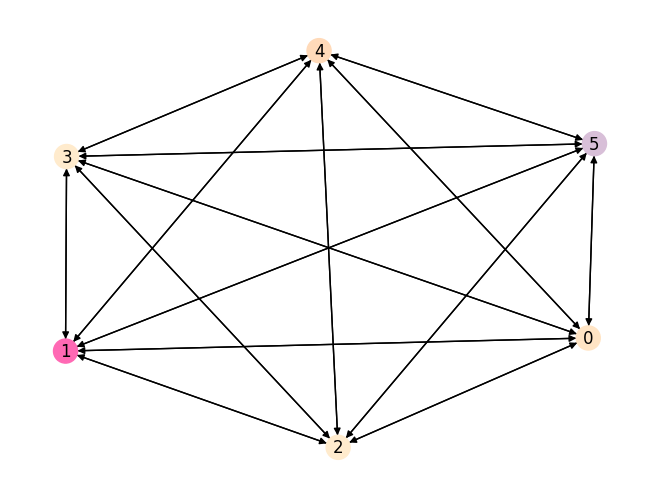

In [186]:
relacion_str = input("Introduce las aristas del grafo:" )
relacion_set_ = eval(relacion_str)
one_step(relacion_set_, population_size_, max_iterations_, pc_, name_of_colors)